# ユーティリティースケールの量子最適化問題を解く

*Estimated QPU usage: 8 minutes (tested on IBM Sherbrooke)*

このチュートリアルでは、Qiskit patternsのコンテキスト内で、ハイブリッド (量子-古典) 反復法である **量子近似最適化アルゴリズム (Quantum Approximate Optimization Algorithm, QAOA)** を実装する方法を説明します。最初に小さなグラフの **最大カット(またはMax-Cut)** 問題を解決し、次にそれをユーティリティースケールで実行する方法を学びます。ノートブック内のすべてのハードウェア実行は、自由にアクセスできるオープンプランの制限時間内に実行される必要があります。

最大カット問題は、クラスタリング、ネットワーク サイエンス、統計物理学など、さまざまな分野で応用されている、解決が難しい (より具体的には *NP 困難* ) 最適化問題です。このチュートリアルでは、頂点で接続されたノードのグラフを検討し、グラフが最大限大きくなるようにグラフを分割することを目標とします。言い換えると、この問題の目的は、グラフのノードを 2 つのセットに分割し、このカットによって横断されるエッジの数を最大化することです。

![Illustration of a max-cut problem](https://learning-api.quantum.ibm.com/assets/0de75f52-4873-4b5a-a0e9-a351dc48c910)


## 要件
このチュートリアルを開始する前に、以下がインストールされていることを確認してください：

* Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
* Rustworkx graph library (`pip install rustworkx`)


## Part 1: 小規模QAOA
このチュートリアルの最初の部分では、小規模な最大カット問題を使用して、量子コンピューターを使用して最適化問題を解決する手順を説明します。

この問題を量子アルゴリズムにマッピングする前に、まず関数 $f(x)$ の最小化を考えることで、最大カット問題が古典的な組み合わせ最適化問題になる仕組みをよりよく理解することができます。

$$
\min_{x\in \{0, 1\}^n}f(x),
$$


ここで、入力 $x$ は、グラフの各ノードに対応する要素を持つベクトルです。次に、これらの各要素を $0$ または $1$ (カットに含まれるか含まれないかを表す) のいずれかに制限します。この小規模な例では、$n=5$ ノードを持つグラフを使用します。

対応するエッジ $(i,j)$ がカット内にあるかどうかを示すノードのペア $i,j$ の関数を記述できます。たとえば、関数 $x_i + x_j - 2 x_i x_j$ は、$x_i$ または $x_j$ のいずれかが 1 (エッジがカット内にあることを意味する) の場合にのみ 1 になり、それ以外の場合は 0 になります。カット内のエッジを最大化する問題は、次のように定式化できます。

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j,
$$

これは、次の形式の最小化として書き直すことができる。

$$
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j.
$$
この場合の $f(x)$ の最小値は、カットが通過するエッジの数が最大になるときです。ご覧のとおり、量子コンピューティングに関連するものはまだありません。この問題を量子コンピューターが理解できるものに再定式化する必要があります。

$n=5$ 個のノードを持つグラフを作成して問題を初期化します。

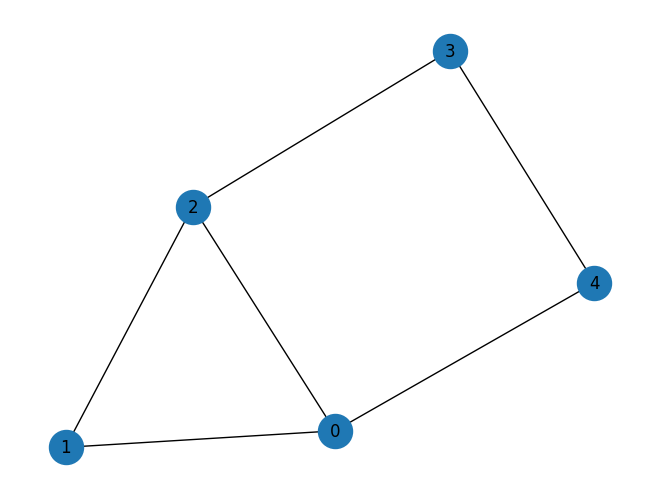

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

### Step 1. 古典的な入力を量子問題にマッピングする

Pattern の最初のステップは、古典的な問題 (グラフ) を量子 **回路** と **演算子** にマッピングすることです。これを行うには、主に次の 3 つのステップを実行します：

1. 一連の数学的再定式化を利用して、この問題を二次制約なしバイナリ最適化 (Quadratic Unconstrained Binary Optimization, QUBO) 問題の表記法を使用して表します。
2. 最適化問題を、コスト関数を最小化する解に対応する基底状態を持つハミルトニアンとして書き直します。
3. 量子アニーリングに似たプロセスを介してこのハミルトニアンの基底状態を準備する量子回路を作成します。

**注:** QAOA 方法論では、最終的には、ハイブリッド アルゴリズムの **コスト関数** を表す演算子 (**ハミルトニアン**)と、問題に対する候補ソリューションを持つ量子状態を表すパラメーター化された回路 (**Ansatz**) が必要になります。これらの候補状態からサンプリングし、コスト関数を使用して評価することができます。


#### グラフ → 最適化問題

マッピングの最初のステップは表記の変更です。以下は問題を QUBO 表記で表現したものです：

$$
\min_{x\in \{0, 1\}^n}x^T Q x,
$$

ここで、$Q$ は実数の $n\times n$ 行列、$n$ はグラフ内のノード数、$x$ は上で紹介したバイナリー変数のベクトル、$x^T$ はベクトル $x$ の転置を示します。

```
Maximize
 -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 + 3*x_0
 + 2*x_1 + 3*x_2 + 2*x_3 + 2*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4
```


### 最適化問題 → ハミルトニアン

次に、QUBO 問題を **ハミルトニアン** (ここではシステムのエネルギーを表す行列) として再定式化できます：

$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
$$

> **QAOA問題からハミルトニアンへの再定式化手順**


> QAOA問題をこのように書き直す方法を示すために、まずバイナリー変数$x_i$を以下を使って、新しい変数セット$z_i\in\{-1, 1\}$に置き換えます。
>
> $$
> x_i = \frac{1-z_i}{2}.
> $$
>
> ここで、$x_i$ が $0$ の場合、$z_i$ は $1$ でなければならないことがわかります。最適化問題 ($x^TQx$) において、 $z_i$ を $x_i$ に置き換えると、同等の定式化が得られます。
>
> $$
> x^TQx=\sum_{ij}Q_{ij}x_ix_j \\ =\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j) \\=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
> $$
>
> ここで、$b_i=-\sum_{j}(Q_{ij}+Q_{ji})$と定義し、前置因子と定数$n^2$項を削除すると、同じ最適化問題の2つの同等な定式化が得られます。
>
> $$
> \min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
> $$
>
> ここで、$b$ は $Q$ に依存します。$z^TQz + b^Tz$ を取得するために、最適化では役割を果たさない係数 1/4 と定数オフセット $n^2$ を削除したことに注意してください。
>
> さて、問題の量子定式化を得るために、$z_i$変数をパウリ$Z$行列、以下のような$2\times 2$行列に昇格させます。
> 
> $$
> Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
> $$
>
> これらの行列を上記の最適化問題に代入すると、次のハミルトニアンが得られます。
> $$
> H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
> $$
>
> *また、$Z$ 行列は量子コンピュータの計算空間、つまりサイズ $2^n\times 2^n$ のヒルベルト空間に埋め込まれていることを思い出してください。したがって、$Z_iZ_j$ などの用語は、$2^n\times 2^n$ ヒルベルト空間に埋め込まれたテンソル積 $Z_i\otimes Z_j$ として理解する必要があります。たとえば、5 つの決定変数を持つ問題では、用語 $Z_1Z_3$ は、$I$ が $2\times 2$ 単位行列である $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ を意味すると理解されます。*

このハミルトニアンは、<b>コスト関数ハミルトニアン</b>と呼ばれます。その基底状態は、<b>コスト関数 $f(x)$ を最小化する</b>解に対応するという特性があります。
したがって、最適化問題を解くためには、量子コンピューター上で $H_C$ の基底状態 (またはそれと重なり合う状態) を準備する必要があります。次に、この状態からサンプリングすると、高い確率で $min~f(x)$ の解が得られます。

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


#### ハミルトニアン → 量子回路


ハミルトニアン $H_c$ には、問題の量子定義が含まれています。これで、量子コンピューターから適切なソリューションを *サンプリング* するのに役立つ量子回路を作成できます。QAOA は量子アニーリングにヒントを得て、量子回路に交互のレイヤーの演算子を適用します。

一般的な考え方は、既知のシステムの基底状態 (上記の $H^{\otimes n}|0\rangle$) から開始し、次にシステムを関心のあるコスト演算子の基底状態に誘導することです。これは、角度 $\gamma_1,...,\gamma_p$ および $\beta_1,...,\beta_p~$ で演算子 $\exp\{-i\gamma_k H_C\}$ および $\exp\{-i\beta_k H_m\}$ を適用することで行われます。

生成する量子回路は $\gamma_i$ と $\beta_i$ によって **パラメーター化** されるため、$\gamma_i$ と $\beta_i$ の異なる値を試し、結果の状態からサンプリングすることができます。


![Circuit diagram with QAOA layers](https://learning-api.quantum.ibm.com/assets/29a70f21-b453-4df7-b726-19468e5b1f51)

この場合、2 つのパラメーター $\gamma_1$ と $\beta_1$ を含む 1 つの QAOA レイヤーの例を試します。

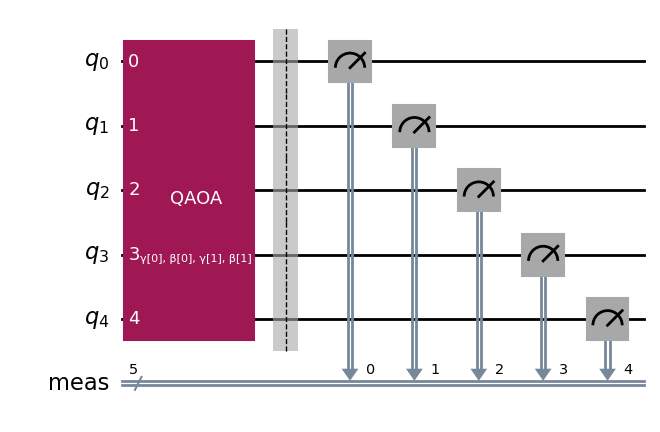

In [3]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [4]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

### Step 2. 量子ハードウェア実行用に回路を最適化する



上記の回路には、量子アルゴリズムを考えるのに役立つ一連の抽象化が含まれていますが、ハードウェア上で実行することはできません。QPU 上で実行できるようにするには、回路は、Pattern の **トランスパイル** または **回路最適化** ステップを構成する一連の操作を実行する必要があります。

Qiskit ライブラリは、さまざまな回路変換に対応する一連の **transpilation passes** を提供します。回路があなたの目的に合わせて **最適化** されていることを確認する必要があります。

トランスパイルには、次のようないくつかの手順が含まれる場合があります：

* **Initial mapping** ：回路内の量子ビット (決定変数など) をデバイス上の物理量子ビットに初期マッピングします。
* **Unrolling** ：量子回路内の命令を、バックエンドが理解できるハードウェアネイティブ命令に展開します。
* **Routing** ：互いに隣接する物理量子ビットと相互作用する回路内の量子ビットのルーティング。
* **Error suppression** ：ダイナミックデカップリングによりノイズを抑制するために単一量子ビットゲートを追加することでエラーを抑制します。

トランスパイルの詳細については、[ドキュメント](https://docs.quantum.ibm.com/transpile) をご覧ください。

次のコードは、抽象回路を、**Qiskit IBM Runtime service** を使用してクラウド経由でアクセス可能なデバイスの 1 つで実行できる形式に変換および最適化します。


<IBMBackend('ibm_kyiv')>


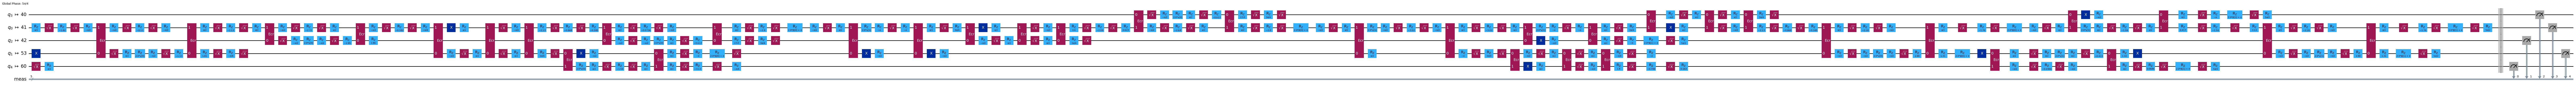

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

### Step 3. Qiskit primitives を使って実行する

QAOA ワークフローでは、一連の回路評価を実行し、古典オプティマイザーを使用して最適な $\beta_k$ および $\gamma_k$ パラメーターを見つける反復最適化ループで最適な QAOA パラメーターが見つかります。この実行ループは、次の手順で実行されます。

1. 初期パラメーターを定義する
2. 最適化ループと回路のサンプリングに使用するprimitiveを含む新しい `Session` をインスタンス化します
3. 最適なパラメーターセットが見つかったら、回路を最後にもう一度実行して、後処理ステップで使用する最終的な分布を取得します。

#### 初期パラメーターで回路を定義する

任意に選択したパラメーターから始めます。


In [10]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

#### バックエンドと実行primitiveを定義

**Qiskit Runtime primitives** を使用して IBM® バックエンドとやりとりします。2 つの primitive は Sampler と Estimator で、primitive の選択は量子コンピューターで実行する測定の種類によって異なります。$H_c$ の最小化には Estimator を使用します。コスト関数の測定が単に $\langle H_c \rangle$ の期待値であるためです。


#### 実行する

Primitiveは量子デバイス上のワークロードをスケジューリングするためのまざまな [execution modes](https://docs.quantum.ibm.com/run/execution-modes) を提供し、QAOA ワークフローがセッション内で繰り返し実行されます。

![Illustration showing the behavior of Single job, Batch, and Session runtime modes.](https://learning-api.quantum.ibm.com/assets/73e400b1-e5a9-4ee8-9842-3e2bbfbef3f5)

Samplerベースのコスト関数を SciPy 最小化ルーチンにプラグインして、最適なパラメーターを見つけることができます。

In [11]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [12]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.9252549900345741
       x: [ 3.271e+00  2.874e+00  2.641e+00  9.339e-01]
    nfev: 35
   maxcv: 0.0


オプティマイザーは、コストを削減し、回路のより良いパラメータを見つけることができました。

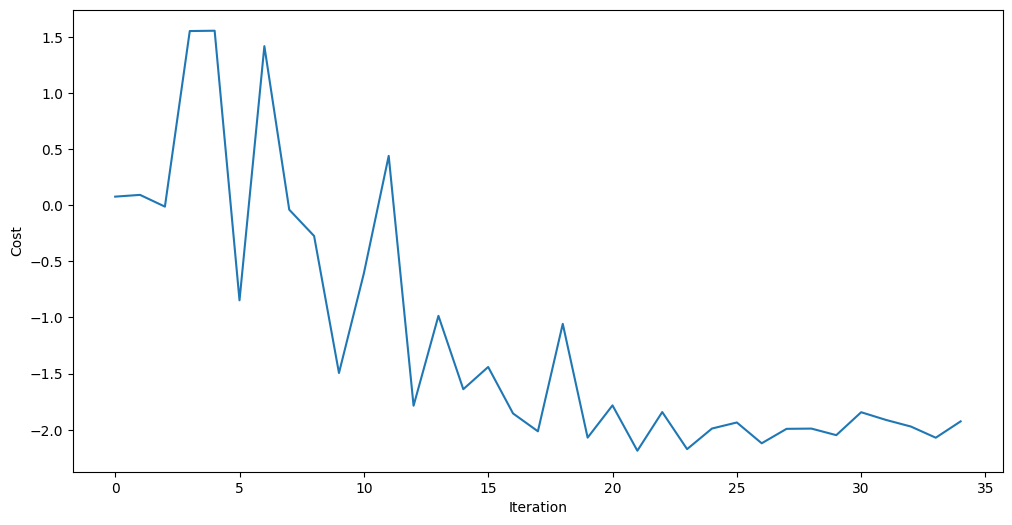

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

回路の最適なパラメーターが見つかったら、これらのパラメーターを割り当て、最適化されたパラメーターで得られた最終的な分布をサンプリングできます。グラフの最適なカットに対応するビット文字列測定の確率分布であるため、ここでは *Sampler* primitive を使用する必要があります。

**注:** これは、コンピューターで量子状態 $\psi$ を準備し、それを測定することを意味します。測定により、状態は単一の計算基底状態 (たとえば、`010101110000...`) に収縮されます。これは、初期最適化問題に対する候補解 $x$ (タスクに応じて $\max f(x)$ または $\min f(x)$) に対応します。

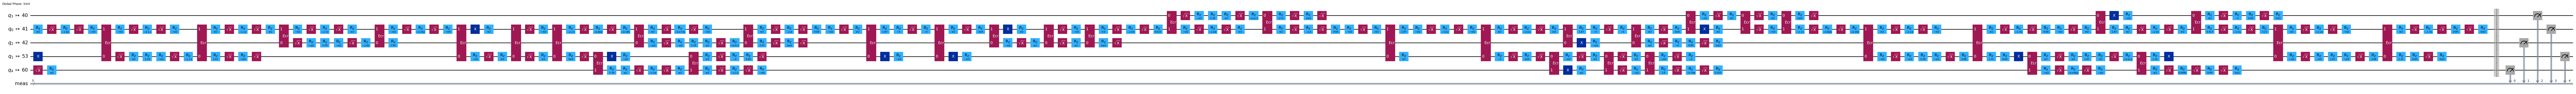

In [14]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [15]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{16: 0.0356, 18: 0.0753, 10: 0.0456, 21: 0.0456, 8: 0.0159, 19: 0.0288, 17: 0.0385, 1: 0.0234, 11: 0.0955, 31: 0.0038, 22: 0.0732, 28: 0.0137, 20: 0.08, 9: 0.0977, 6: 0.0138, 30: 0.0102, 2: 0.0127, 26: 0.0532, 13: 0.0354, 27: 0.0114, 0: 0.0087, 4: 0.0092, 5: 0.0432, 14: 0.0195, 25: 0.0196, 3: 0.0264, 24: 0.0128, 12: 0.0164, 15: 0.0094, 23: 0.009, 7: 0.0111, 29: 0.0054}


### Step 4. 後処理を行い、結果を従来の形式で返す

後処理ステップでは、サンプリング出力を解釈して、元の問題のソリューションを返します。この場合、最適なカットを決定する最も高い確率を持つビット文字列に注目します。問題の対称性により 4 つのソリューションが可能になり、サンプリング プロセスではそのうちの 1 つがわずかに高い確率で返されますが、以下のプロットされた分布では、ビット文字列のうち 4 つが他のビット文字列よりも明らかに可能性が高いことがわかります。


In [16]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 0]


/var/folders/dk/j4n5f_1d3xs7m8bq81g9gfk80000gn/T/ipykernel_76646/1639367914.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


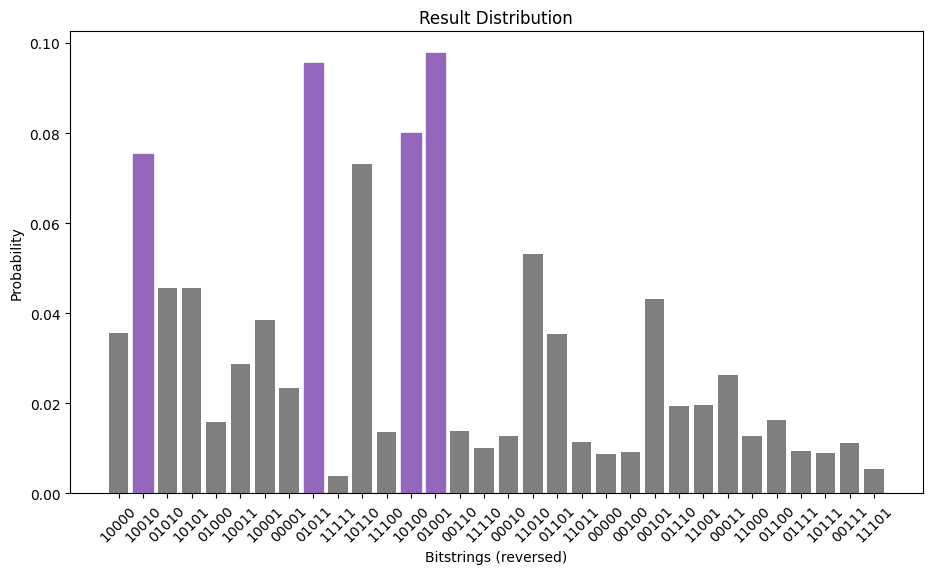

In [17]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

#### ベストなカットを視覚化
最適なビット文字列から、このカットを元のグラフ上で視覚化できます。


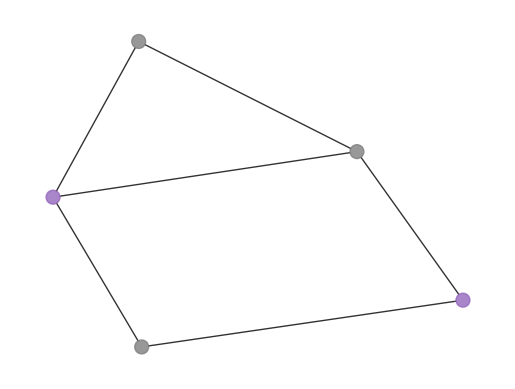

In [18]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

そして、カットの値を計算します。


In [27]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 5


## Part 2: スケールアップしましょう!
IBM Quantum Platform では、100 を超える量子ビットを備えた多数のデバイスにアクセスできます。100 ノードの重み付きグラフで最大カットを解くデバイスを 1 つ選択します。これは「ユーティリティースケール」の問題です。ワークフローを構築する手順は上記と同じですが、グラフははるかに大きくなります。

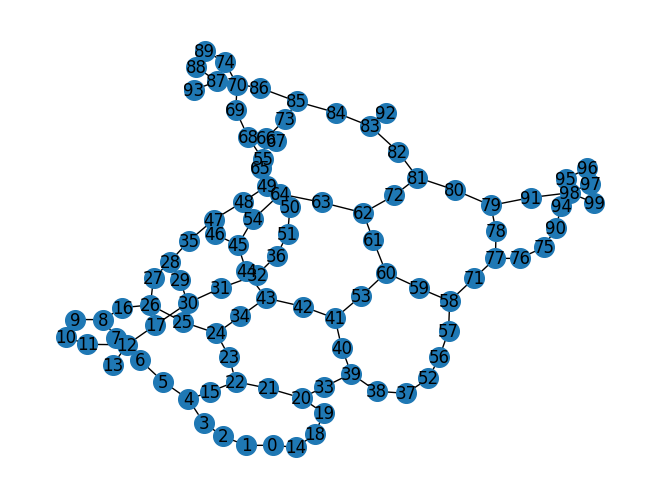

In [30]:
n = 100  # Number of nodes in graph
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)

### Step 1. 古典的な入力を量子問題にマッピングする

#### グラフ → ハミルトニアン
まず、解きたいグラフを QAOA に適したハミルトニアンに直接変換します。

In [31]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

#### ハミルトニアン → 量子回路


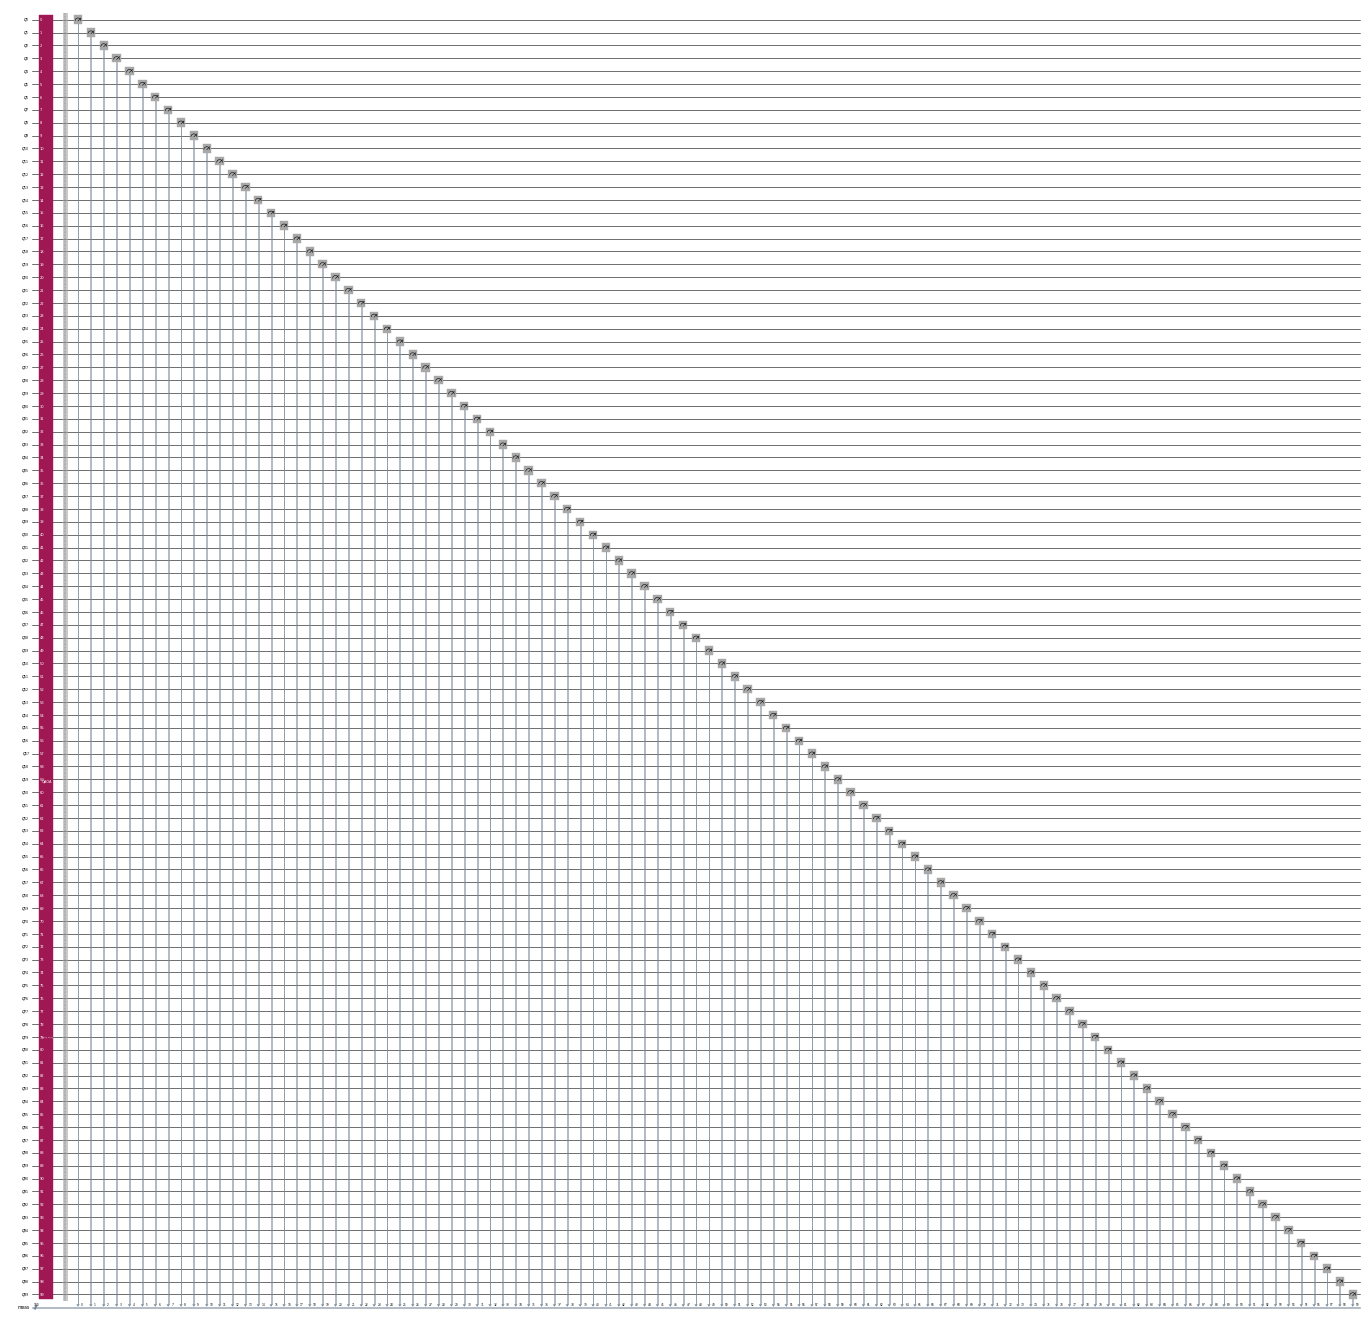

In [33]:
from qiskit.circuit.library import QAOAAnsatz

circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

### Step 2. 量子実行のための問題の最適化

回路最適化ステップをユーティリティースケールの問題に拡張するには、Qiskit SDK v1.0で導入された高性能トランスパイルストラテジーを活用できます。その他のツールには、 [AI enhanced transpiler passes](https://docs.quantum.ibm.com/transpile/ai-transpiler-passes)による新しいトランスパイラサービスが含まれます。

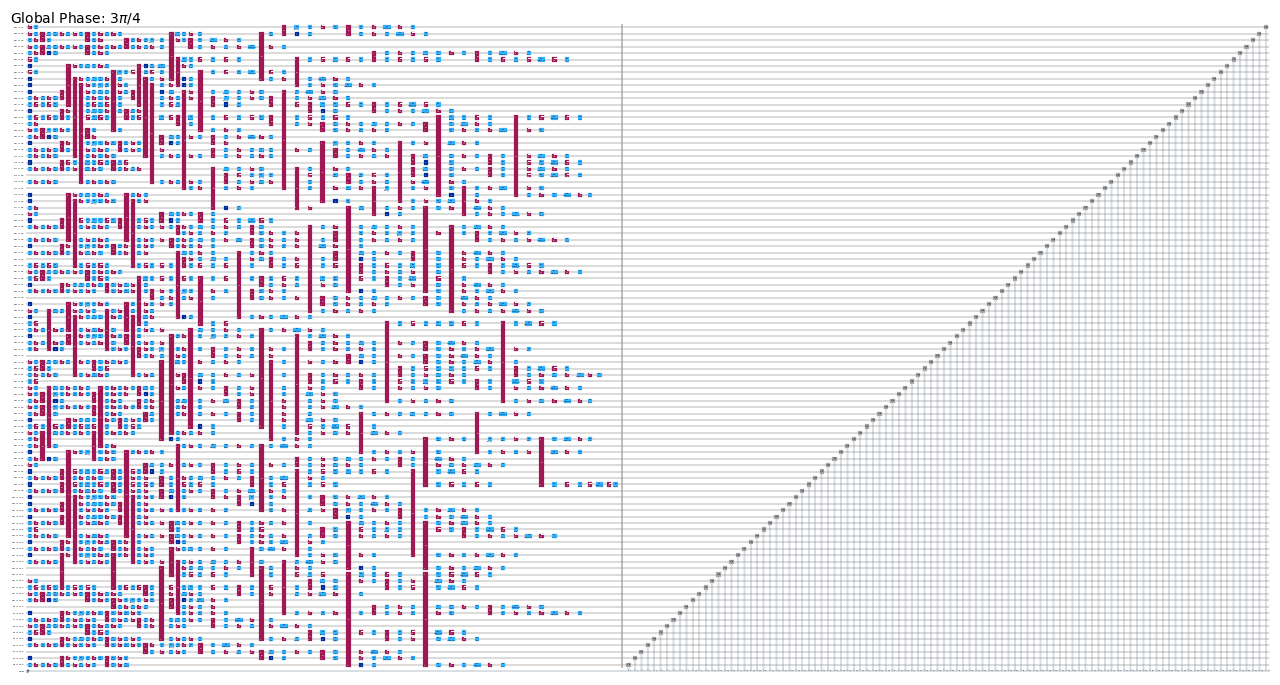

In [34]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw('mpl', fold=False, scale=0.1, idle_wires=False)

### Step 3. Qiskit primitivesを使用して実行する
QAOA を実行するには、変分回路に入れる最適なパラメーター $\gamma_k$ と $\beta_k$ を知っておく必要があります。デバイス上で最適化ループを実行して、これらのパラメーターを最適化します。セルは、コスト関数値が収束し、$\gamma_k$ と $\beta_k$ の最適なパラメーターが決定されるまでジョブを送信します。

#### デバイス上で最適化を実行して候補ソリューションを見つける


まず、デバイス上の回路パラメーターの最適化ループを実行します。

In [35]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, estimator),
        method="COBYLA",
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -43.594336255533044
       x: [ 2.751e+00  3.347e-01]
    nfev: 30
   maxcv: 0.0


デバイス上でQAOAを実行して最適なパラメーターが見つかったら、そのパラメーターを回路に割り当てます。

In [36]:
optimized_circuit_100 = candidate_circuit_100.assign_parameters(result.x)
optimized_circuit_100.draw('mpl', fold=False, idle_wires=False)

最後に、最適なパラメーターを使用して回路を実行し、対応する分布からサンプリングします。

In [37]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"


pub= (optimized_circuit_100, )
job = sampler.run([pub], shots=int(1e4))

counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_100_int = {key: val/shots for key, val in counts_int.items()}

### Step 4. 後処理を行い、結果を従来の形式で返す


最適化ループで最小化されたコストが特定の値に収束したことを確認します。以下のコードでは、コストの最小値に対応するパラメーターを使用しています。

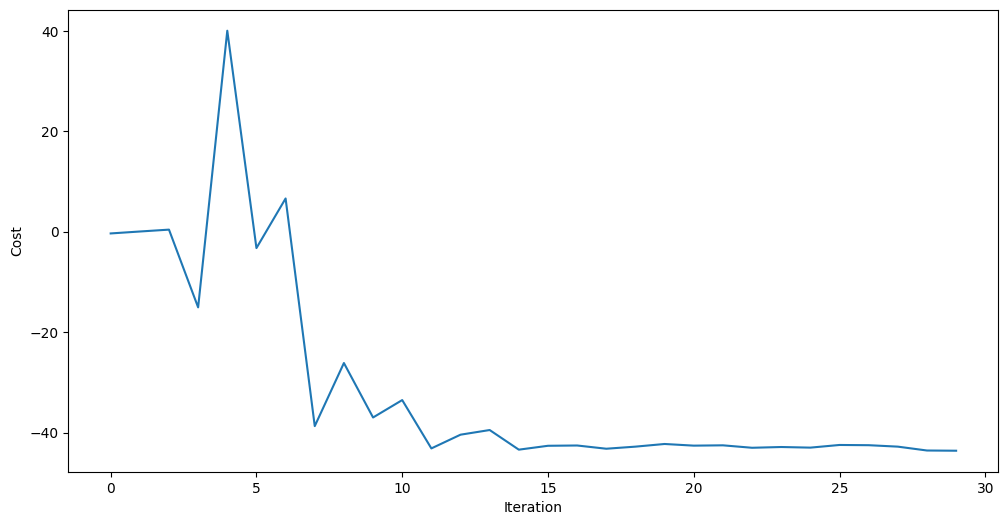

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

各ソリューションの可能性が低いことを考慮して、コストが最も低いソリューションを抽出します。

In [39]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_cost = 1000
    min_sol = None
    for bit_str in samples.keys():
        # Qiskit use little endian hence the [::-1]
        candidate_sol = int(bit_str)
        # fval = qp.objective.evaluate(candidate_sol)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        if fval <= min_cost:
            min_sol = candidate_sol

    return min_sol

best_sol_100 = best_solution(final_distribution_100_int, cost_hamiltonian_100)
best_sol_bitstring_100 = to_bitstring(int(best_sol_100), len(graph_100))
best_sol_bitstring_100.reverse()

print("Result bitstring:", best_sol_bitstring_100)

Result bitstring: [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]


次に、カットを視覚化します。同じ色のノードは同じグループに属します。

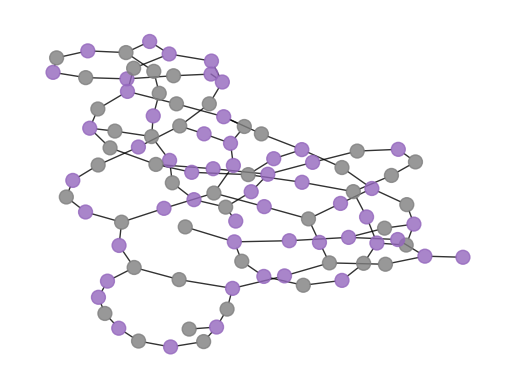

In [40]:
plot_result(graph_100, best_sol_bitstring_100)

そしてカットの価値を計算します。


In [41]:
cut_value_100= evaluate_sample(best_sol_bitstring_100, graph_100)
print('The value of the cut is:', cut_value_100)

The value of the cut is: 84


次に、量子コンピューターで測定した各サンプルの目的値を計算する必要があります。目的値が最も低いサンプルが、量子コンピューターによって返される解です。

In [42]:
from collections import defaultdict
import matplotlib.pyplot as plt

# auxiliary function to help plot cumulative distribution functions
def _plot_cdf(objective_values: dict, ax, color):
    x_vals = sorted(objective_values.keys(), reverse=True)
    y_vals = np.cumsum([objective_values[x] for x in x_vals])
    ax.plot(x_vals, y_vals, color=color)


def plot_cdf(dist, ax, title):
    _plot_cdf(dist, ax, "C1",)
    ax.vlines(min(list(dist.keys())), 0, 1, "C1", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Objective function value")
    ax.set_ylabel("Cumulative distribution function")
    ax.grid(alpha=0.3)

# auxiliary function to convert bit-strings to objective values
def samples_to_objective_values(samples, hamiltonian):
    """Convert the samples to values of the objective function."""

    objective_values = defaultdict(float)
    for bit_str, prob in samples.items():
        candidate_sol = int(bit_str)
        fval = evaluate_sparse_pauli(candidate_sol, hamiltonian).real
        objective_values[fval] += prob

    return objective_values

In [43]:
result_dist = samples_to_objective_values(final_distribution_100_int, cost_hamiltonian_100)

最後に、累積分布関数をプロットして、各サンプルが全体の確率分布と対応する目的値にどのように寄与するかを視覚化できます。水平方向の広がりは、最終的な分布におけるサンプルの目的値の範囲を示します。理想的には、累積分布関数が目的関数値軸の下端で「ジャンプ」しているのがわかります。これは、サンプリングされる確率が高い、コストの低い解がほとんどないことを意味します。滑らかで幅の広い曲線は、各サンプルが同じような確率であることを示し、目的値が低いか高いかで大きく異なる可能性があることを示します。

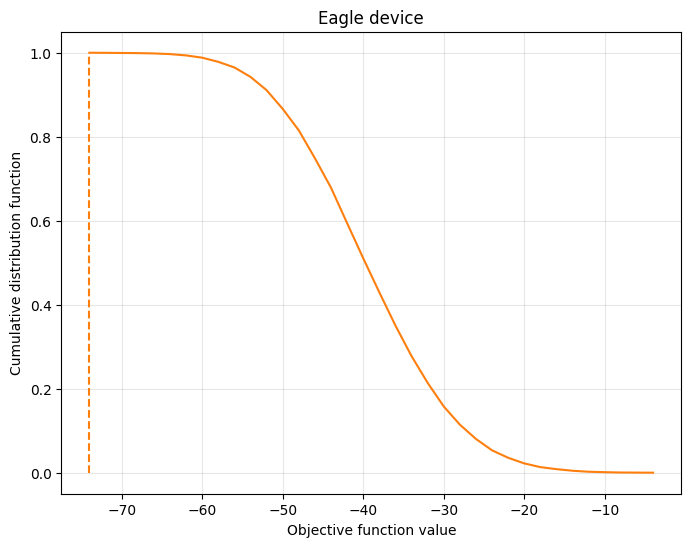

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_cdf(result_dist, ax, "Eagle device")

## 結論
このチュートリアルでは、Qiskit patterns フレームワークを使用して量子コンピューターで最適化問題を解決する方法を示しました。このデモには、従来の方法では正確にシミュレートできない回路サイズのユーティリティースケールの例が含まれていました。現在、量子コンピューターは、ノイズのため、組合せ最適化において従来のコンピューターよりも優れた性能を発揮してはいません。ただし、ハードウェアは着実に改善されており、量子コンピューターの新しいアルゴリズムが継続的に開発されています。実際、組合せ最適化のための量子ヒューリスティックに取り組んでいる研究の多くは、少数の量子ビット（通常は20量子ビット程度）しか使用できない古典的シミュレーションでテストされています。しかし、量子ビットの数が増え、ノイズの少ないデバイスが開発されれば、研究者たちは、量子ハードウェアを使った大規模な問題での量子ヒューリスティックのベンチマークを開始することができるでしょう。

